In [2]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

Added: /Users/lsanchez/omath_mota_rulo


In [4]:
from omath_mota_rulo.data import capacidad_hospitalaria

In [5]:
data = capacidad_hospitalaria.get()

In [7]:
data['fields.fecha'] = pd.to_datetime(data['fields.fecha'])

In [16]:
capacidad = {}
for date, date_data in data.groupby('fields.fecha'):
    capacidad[date] = date_data['fields.estatus_capacidad_uci'].value_counts()
    
capacidad = pd.DataFrame(capacidad).T

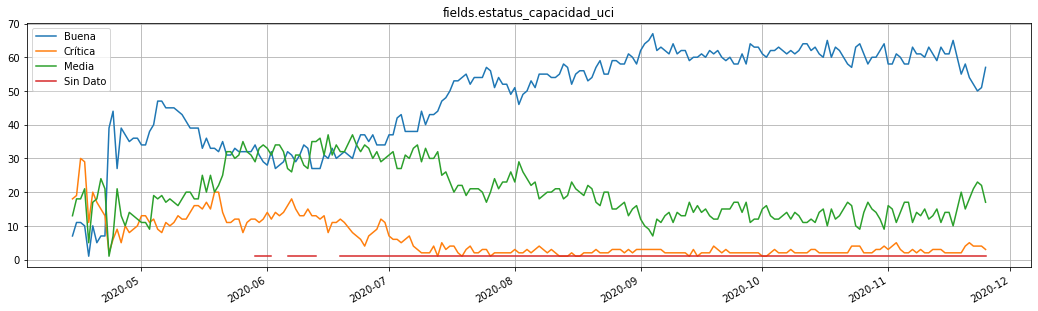

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

capacidad.plot(
    title='fields.estatus_capacidad_uci',
    ax=ax,
    grid=True)